# First Look
## 가맹점 미이용 고객 vs 가맹점 이용 고객
- 가맹점 미이용 고객: `MRC_ID_DI==0` in samp_train
- 가맹점 이용 고객: others

In [5]:
import os, glob

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

plt.style.use('seaborn')
plt.rcParams["font.family"] = 'AppleSDGothicNeoSB00'
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
pathList = glob.glob('../data/provided/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


In [7]:
varNums = variable_dtype[variable_dtype['dType']=='numerical']['Variable_Name'].tolist()

In [8]:
# 분포 차이가 매우 큼
diff_high = ['VAR008', 'VAR042', 'VAR090', 'VAR101', 'VAR126', 'VAR138', 'VAR167', 'VAR197']

# 분포 차이가 있는 편: 분포의 일정 구간이 덩어리째로 사라짐
diff_medium = ['VAR003', 'VAR010', 'VAR016', 'VAR017', 'VAR021', 'VAR025', 'VAR029', 'VAR031', 
               'VAR034', 'VAR036', 'VAR043', 'VAR047', 'VAR056', 'VAR062', 'VAR080', 'VAR093', 
               'VAR103', 'VAR104', 'VAR106', 'VAR109', 'VAR114', 'VAR115', 'VAR117', 'VAR122', 
               'VAR126', 'VAR147', 'VAR149', 'VAR153', 'VAR157', 'VAR174', 'VAR184', 'VAR187', 
               'VAR192', 'VAR200', 'VAR215', 'VAR218', 'VAR219', 'VAR222' ]
# 분포 차이가 적은 편: 분포의 아주 특정 구간이 사라짐
diff_low = ['VAR005', 'VAR009', 'VAR020', 'VAR023', 'VAR030', 'VAR037', 'VAR044', 'VAR045', 
            'VAR072', 'VAR074', 'VAR083', 'VAR086', 'VAR088', 'VAR099', 'VAR100', 'VAR102', 
            'VAR110', 'VAR112', 'VAR113', 'VAR129', 'VAR132', 'VAR135', 'VAR142', 'VAR146', 
            'VAR151', 'VAR155', 'VAR163', 'VAR180', 'VAR193', 'VAR194', 'VAR195', 'VAR201', 
            'VAR206', 'VAR207', 'VAR213', 'VAR220', 'VAR221', 'VAR223', 'VAR225']

In [9]:
worthObserving = pd.DataFrame()
worthObserving['VAR'] = diff_high + diff_medium + diff_low
worthObserving['Importance'] = ['HIGH']*len(diff_high) + ['MEDIUM']*len(diff_medium) \
                            + ['LOW']*len(diff_low)
worthObserving.to_csv('../data/processed/가맹점이용여부_유의미한VAR.csv', index=False)

In [34]:
def getCustomerGroup(group, complement=False):
    '''
    특정 가맹점을 이용한 고객만을 추려내는 함수
    group: list, 가맹점 번호가 성분임
    complement: boolean, 입력한 group에 해당하지 않는 고객을 가져올 경우 True
    ---
    Return: 고객ID 시리즈
    '''
    return (samp_train[~samp_train['MRC_ID_DI'].isin(group)]['cst_id_di'].tolist() if complement 
            else samp_train[samp_train['MRC_ID_DI'].isin(group)]['cst_id_di'].tolist())

In [133]:
# 미이용
noFranchise = samp_cst_feat[samp_cst_feat['cst_id_di']\
                            .isin(getCustomerGroup(group=[0]))]
yesFranchise = samp_cst_feat[samp_cst_feat['cst_id_di']\
                             .isin(getCustomerGroup(group=[0], complement=True))]

def getPlot(features):
    '''
    인풋한 데이터의 모든 컬럼의 plot 리턴
    data: pandas.core.frame.DataFrame
    '''
    noFranchise = samp_cst_feat[samp_cst_feat['cst_id_di']\
                            .isin(getCustomerGroup(group=[0]))]
    yesFranchise = samp_cst_feat[samp_cst_feat['cst_id_di']\
                             .isin(getCustomerGroup(group=[0], complement=True))]
    
    rows = len(features) // 4 if len(features) % 4 == 0 else len(features) // 4 + 1
    mod = 0
    _, ax = plt.subplots(rows, 4, figsize = (12, rows * 3))
    for idx, f in enumerate(features):
        if idx==0:
            sns.distplot(noFranchise[f], ax=ax[idx, 0], color='#A4A4A4')
            sns.distplot(yesFranchise[f], ax=ax[idx, 0], color='#2E9AFE')
        else:
            if idx % 4 == 0:
                mod += 1
            sns.distplot(noFranchise[f], ax=ax[mod, idx - mod*4], color='#A4A4A4', label='가맹점 미이용')
            sns.distplot(yesFranchise[f], ax=ax[mod, idx - mod*4], color='#2E9AFE', label='가맹점 이용')
                
    plt.tight_layout()

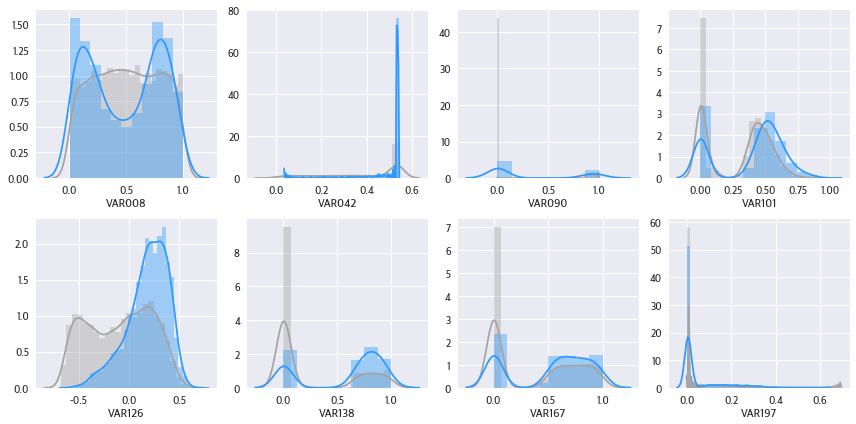

In [134]:
getPlot(features=diff_high)

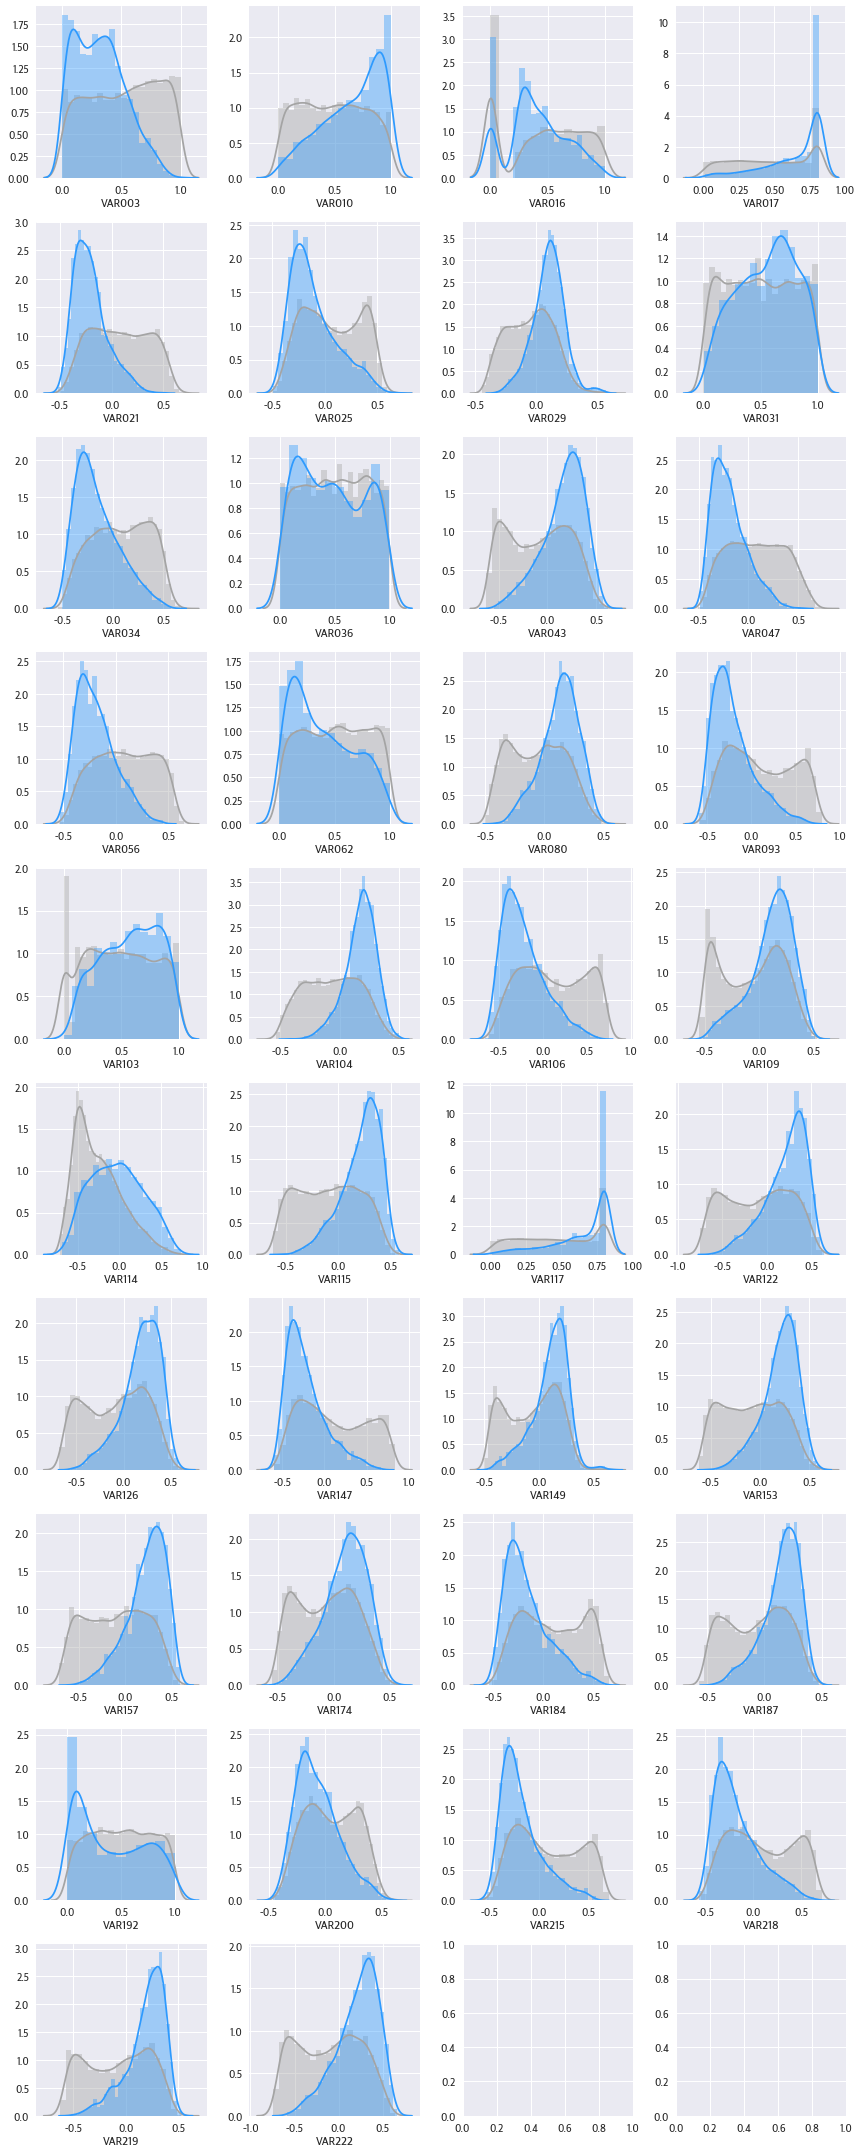

In [135]:
getPlot(features=diff_medium)

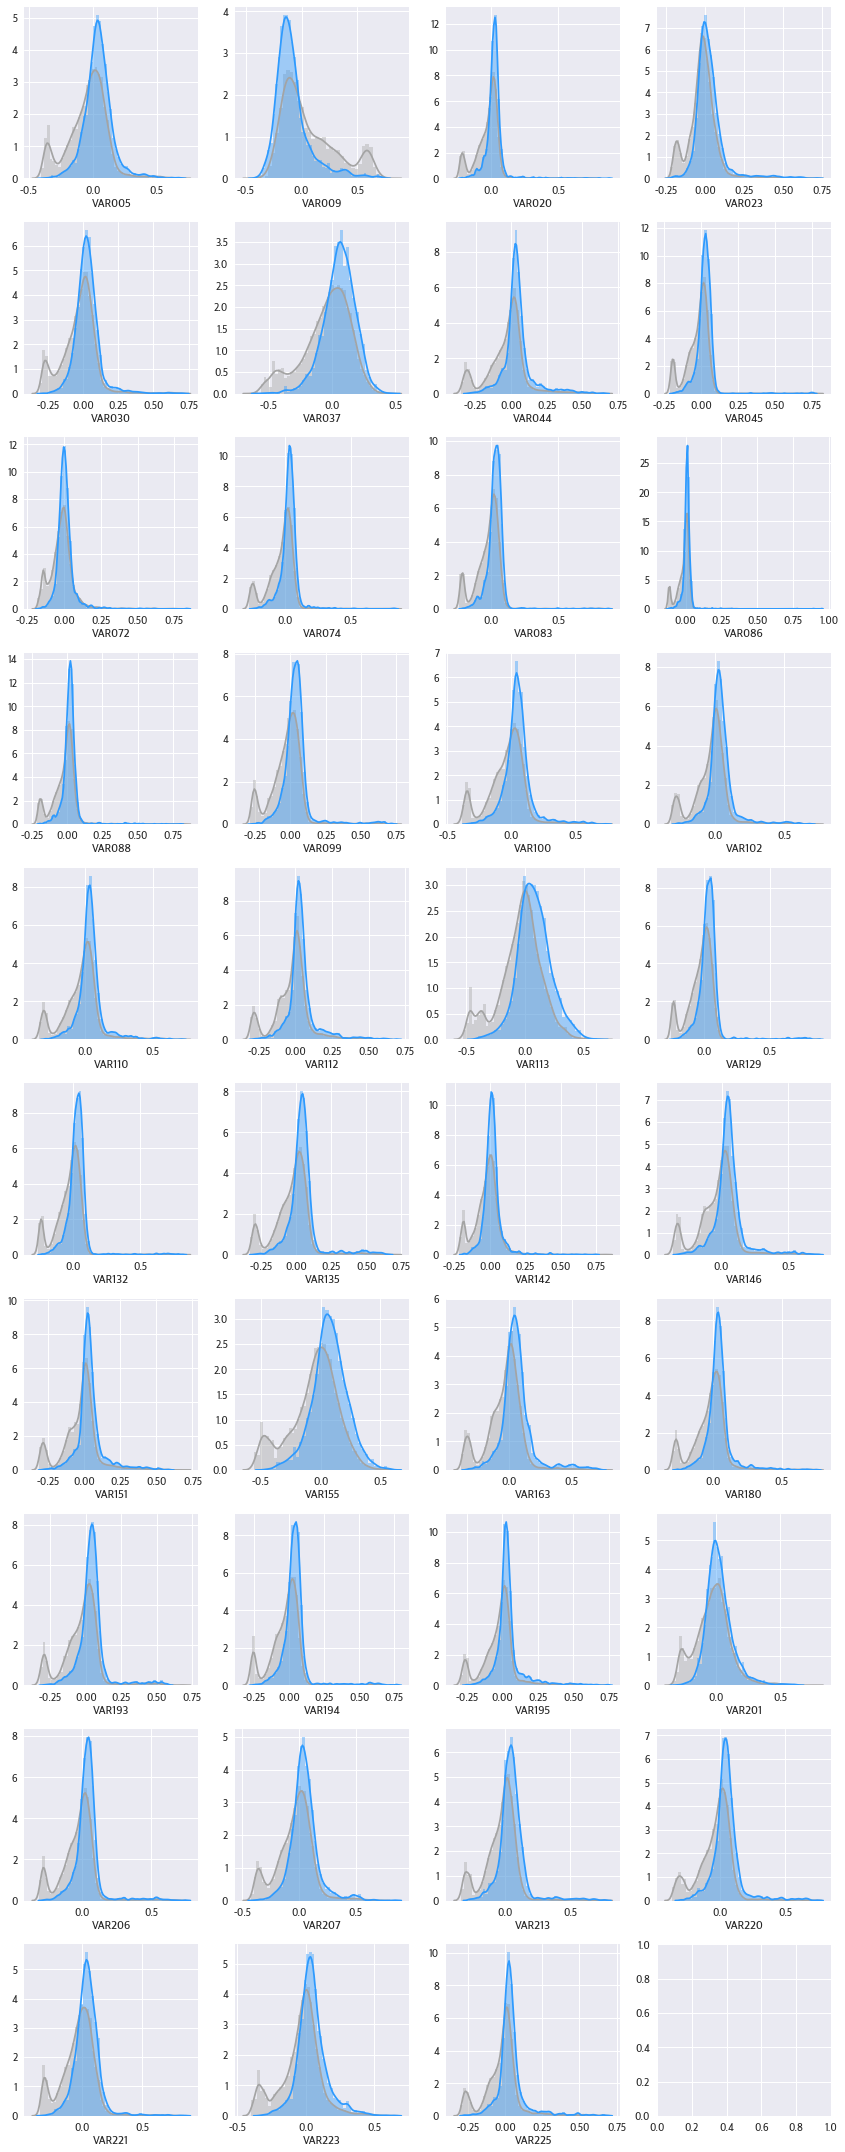

In [136]:
getPlot(features=diff_low)

In [400]:
def getPlot_perVAR(var_num, threshold=None, 
                save=False, path='../plots/각 VAR별 plot/가맹점 미이용 vs 가맹점 이용'):
    '''
    VAR변수에 대한 정보를 담은 plot을 리턴
    var_num: integer, VAR변수의 번호, 가령 23
    threshold: float, 분포를 나누어 관찰하기 위한 분기점, 입력한 VAR의 관찰값 범위 내에 있어야 함
                입력하지 않을 시 입력한 VAR의 임의 값을 분기점으로 지정
    '''
    var = 'VAR' + str(var_num).zfill(3)
    
    if threshold is None:
        np.random.seed(42)
        threshold = np.random.choice(samp_cst_feat[var], size=1)[0]
    merge1 = samp_cst_feat[samp_cst_feat[var] < threshold]\
                 .merge(samp_train, how='left', on='cst_id_di')[['MRC_ID_DI']]
    merge2 = samp_cst_feat[samp_cst_feat[var] >= threshold]\
                 .merge(samp_train, how='left', on='cst_id_di')[['MRC_ID_DI']]
    f, ax = plt.subplots(2,2, figsize=(12, 8))
    sns.countplot(merge1['MRC_ID_DI'], ax=ax[0, 0])
    sns.countplot(merge2['MRC_ID_DI'], ax=ax[0, 1])

    merge1['ID'] = f'{var} < {threshold}'
    merge2['ID'] = f'{var} >= {threshold}'
    
    merge3 = pd.concat([merge1, merge2], axis=0, ignore_index=True)
    temp_idx = merge3[merge3['MRC_ID_DI'] == 0].index
    merge3['MRC_ID_DI'] = '가맹점 이용 고객'
    merge3.loc[temp_idx, 'MRC_ID_DI'] = '가맹점 미이용 고객'
    merge3 = (merge3.groupby('ID')['MRC_ID_DI']
              .value_counts(normalize=True)
              .mul(100)
              .rename('Percent(%)')
              .reset_index())
    
    sns.barplot(x='ID', y='Percent(%)', hue='MRC_ID_DI', data=merge3, ax=ax[1,0])
    sns.distplot(samp_cst_feat[samp_cst_feat['cst_id_di'].isin(getCustomerGroup([0]))][var], 
                 ax=ax[1, 1], color='#A4A4A4')
    sns.distplot(samp_cst_feat[samp_cst_feat['cst_id_di'].isin(getCustomerGroup([0], complement=True))][var], 
                 ax=ax[1, 1], color='#2E9AFE')
    
    ax[0,0].set_title(f'가맹점 별 Frequency\n{var} < {threshold}')
    ax[0,1].set_title(f'가맹점 별 Frequency\n{var} >= {threshold}')
    ax[1,0].set_title(f'분기점 별 가맹점 이용/미이용 비율')
    ax[1,1].set_title(f'{var} 분포\ngray: 가맹점 미이용    blue: 가맹점 이용')
    ax[1,1].axvline(threshold, color='#04B404')
    

    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(path, f'미이용vs이용_VAR{var_num}_threshold_{threshold}.png'), dpi=300)
        print('Saved')
    print('variable:', var)    
    print('threshold:', threshold)

    #     return merge1, merge2, merge3

Saved
variable: VAR167
threshold: 0.25


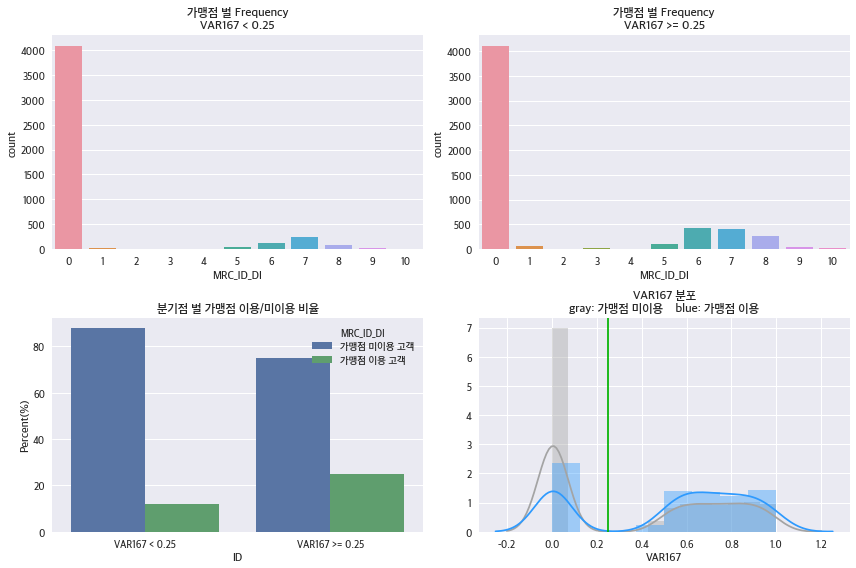

In [399]:
getPlot_perVAR(var_num=167, threshold=0.25, save=True)